#### 确定生成分子的数量
受到参考文献的启发，我们基于多样性指标，研究合适的生成分子数量。即当生成分子的多样性大致收敛时，便为生成上限。

#### Determine the size of molecules to be generated
Inspired by the refenece, we study the appropriate number of generated molecules based on diversity. Specifically, when the diversity of the generated molecules approximately converges, it serves as the upper limit for generation.

#### Reference
```
Özçelik, R., & Grisoni, F. (2024). The Jungle of Generative Drug Discovery: Traps, Treasures, and Ways Out. ArXiv, abs/2501.05457.
```

In [2]:
import numpy as np
from utils.io import read_sdf, standard_mol
from eval.similarity import Similarity
from utils.logger import project_logger
from pathlib import Path
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

- 由于多样性在生成数量较少的分子时变化较大，因此我们采用指数衰减加权随机采样，对前期生成的分子较多地采样，而后期则减少采样。  
- Since diversity varies significantly when generating a smaller number of molecules, we employ exponentially decaying weighted random sampling to sample more initially generated molecules as possible, while reducing sampling in the later stages.

In [3]:
def generate_indices(total_samples=10000, n_samples=48, alpha=4):
    np.random.seed(42)

    indices = np.arange(total_samples)

    weights = np.exp(-alpha * indices / total_samples)
    weights /= weights.sum() 
    sampled_indices = np.random.choice(
        indices, 
        size=n_samples, 
        replace=False, 
        p=weights,
    )
    return np.sort(sampled_indices)

indices = generate_indices()
indices = np.insert(indices, 0, 1)
indices = np.append(indices, 10000)
indices

array([    1,    51,    85,   116,   146,   164,   251,   319,   368,
         415,   458,   491,   496,   545,   584,   732,   841,   844,
         886,   888,   913,  1114,  1145,  1379,  1414,  1484,  1664,
        1757,  1786,  1809,  1939,  2178,  2214,  2229,  2268,  2294,
        2627,  2784,  2969,  3169,  3682,  3944,  4248,  4747,  5579,
        6702,  6768,  7388,  7598, 10000])

In [4]:
def read_in(path):
    mols = []
    for sdffile in Path(path).glob('*.sdf'):
        mols.extend(read_sdf(sdffile))

    total_num = len(mols)
    valids = process_map(standard_mol, mols, chunksize=1000)
    valids = [mol for mol in valids if mol]
    valid_num = len(valids)
    project_logger.info(f'Load {total_num} molecules from {path}, {valid_num} of them is valid.')
    return valids

def intdiv(valids, indices=indices):
    simis = []
    for idx in tqdm(indices):
        simi = Similarity(mols=valids[:idx])
        simis.append(simi.similarity())
    intdiv = [1-sim for sim in simis]
    return intdiv

In [5]:
ht2a = intdiv(read_in('../testfile/DiffSBDD/5HT2A'))

100%|██████████| 10752/10752 [00:00<00:00, 15379.11it/s]


INFO: Load 10752 molecules from ../testfile/DiffSBDD/5HT2A, 10489 of them is valid.


100%|██████████| 50/50 [01:55<00:00,  2.32s/it]


In [6]:
btk = intdiv(read_in('../testfile/DiffSBDD/BTK'))

100%|██████████| 10752/10752 [00:00<00:00, 20032.38it/s]


INFO: Load 10752 molecules from ../testfile/DiffSBDD/BTK, 10485 of them is valid.


100%|██████████| 50/50 [01:52<00:00,  2.25s/it]


In [7]:
nampt = intdiv(read_in('../testfile/DiffSBDD/NAMPT'))

100%|██████████| 11264/11264 [00:00<00:00, 17827.51it/s]


INFO: Load 11264 molecules from ../testfile/DiffSBDD/NAMPT, 10981 of them is valid.


100%|██████████| 50/50 [01:50<00:00,  2.20s/it]


In [8]:
# Smooth with Gaussian Filter (sigma=2)
def smooth(data):
    return gaussian_filter1d(data, sigma=2)

ht2a_sm = smooth(ht2a)
btk_sm = smooth(btk)
nampt_sm = smooth(nampt)

<Axes: >

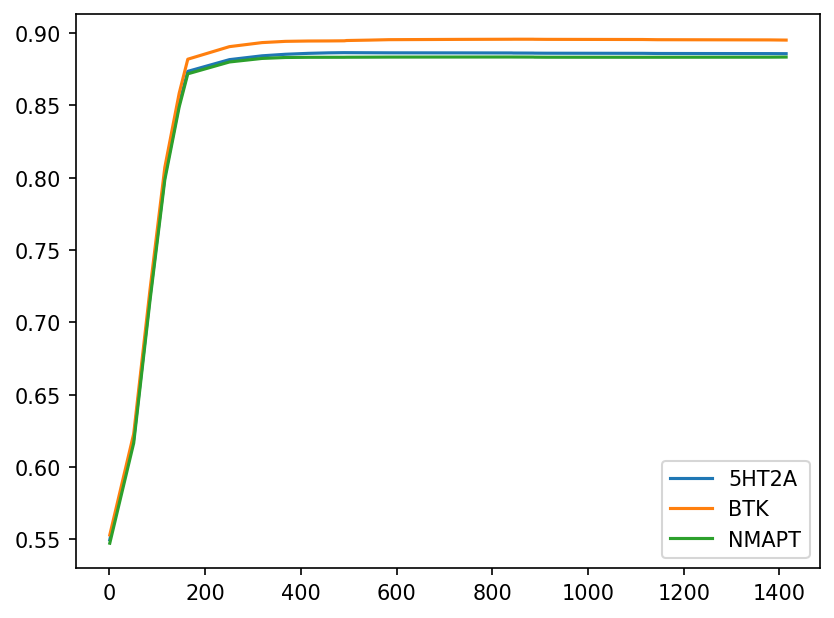

In [15]:
fig, ax = plt.subplots(dpi=150)
sns.lineplot(x=indices[:25], y=ht2a_sm[:25], label="5HT2A")
sns.lineplot(x=indices[:25], y=btk_sm[:25], label="BTK")
sns.lineplot(x=indices[:25], y=nampt_sm[:25], label="NMAPT")